# Frequency Prediction

We will use the frequency dataset created before containing EQ with magnitude $M \geq 4.5$

In [1]:
import pandas as pd
import numpy as np

In [26]:
data_freq = pd.read_csv("monthly_count_1960_2022.csv")
data_freq.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
data_freq.index = pd.to_datetime(data_freq["time"])
data_freq.drop(["time"], inplace=True, axis=1)
data_freq.head()

,A,B,C,D,E,F,G
time,,,,,,,
1960-01-01,0,0,0,1,0,0,0
1960-02-01,0,0,0,0,0,1,0
1960-03-01,0,0,0,0,0,10,0
1960-04-01,0,0,0,0,0,0,0
1960-05-01,0,0,0,0,0,0,0


In [27]:
import plotly.express as px

fig = px.line(data_freq, y=["A", "B", "C", "D", "E"], title="EQ Count by month")
fig.show()

## Prepare Training Data

We will use a sliding window $\tau = 1 \text{ years} $, which amount to 12 periods.  
We will split our data into a training set and a test set. The training set will use data from 1960 to 2011.  Min-Max scaling has also been fitted to the training data to aid convergence of the neural network.

In [71]:
from sklearn.preprocessing import MinMaxScaler

def create_sliding_window(data, sequence_length, stride=1):  # same goal as the previous split_data function
    X, y = [], []
    for i in range(len(data)):
        if i + sequence_length < len(data):
            X.append(data.iloc[i : i + sequence_length : stride, :].values)
            y.append(data.iloc[i + sequence_length, :].values)
    return np.array(X), np.array(y)
        
n_train = 51 * 12  # December 2011

features = ["A"]
feature_array = data_freq[features].values

# Fit Scaler only on Training features
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_array[:n_train])

# Fit Scaler only on training target values
target_scaler = MinMaxScaler()
target_scaler.fit(feature_array[:n_train])

# Transform on both Training and Test set
scaled_array = pd.DataFrame(feature_scaler.transform(feature_array))


sequence_length = 12 # 1 years
X, y = create_sliding_window(scaled_array, sequence_length)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [72]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((612, 12, 1), (612, 1), (120, 12, 1), (120, 1))

## Bayesian LSTM Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [73]:
X_train_tensor = Variable(torch.Tensor(X_train))
X_test_tensor = Variable(torch.Tensor(X_test))

y_train_tensor = Variable(torch.Tensor(y_train))
y_test_tensor = Variable(torch.Tensor(y_test))

In [11]:
class BayesianLSTM(nn.Module):

    def __init__(self, n_features, output_length, batch_size):

        super(BayesianLSTM, self).__init__()

        self.batch_size = batch_size # user-defined

        self.hidden_size_1 = 128 # number of encoder cells (from paper)
        self.hidden_size_2 = 32 # number of decoder cells (from paper)
        self.stacked_layers = 2 # number of (stacked) LSTM layers for each stage
        self.dropout_probability = 0.5 # arbitrary value (the paper suggests that performance is generally stable across all ranges)

        self.lstm1 = nn.LSTM(n_features, 
                             self.hidden_size_1, 
                             num_layers=self.stacked_layers,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=self.stacked_layers,
                             batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)
        output, _ = self.lstm1(x, hidden)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=self.dropout_probability, training=True)
        output = output[:, -1, :] # take the last decoder cell's outputs
        y_pred = self.fc(output)
        return y_pred
        
    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state
    
    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.stacked_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

In [75]:
n_features = scaled_array.shape[-1]
sequence_length = 12
output_length = 1

batch_size = 80
n_epochs = 150
learning_rate = 0.01

bayesian_lstm = BayesianLSTM(n_features=n_features,
                             output_length=output_length,
                             batch_size = batch_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)

In [76]:
bayesian_lstm.train()

for e in range(1, n_epochs+1):
    for b in range(0, len(X_train), batch_size):
        features = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]    

        X_batch = torch.tensor(features,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        output = bayesian_lstm(X_batch)
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    if e % 10 == 0:
      print('epoch', e, 'loss: ', loss.item())

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:520: UserWarning:

Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:520: UserWarning:

Using a target size (torch.Size([52, 1])) that is different to the input size (torch.Size([52])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



epoch 10 loss:  0.0007561182719655335
epoch 20 loss:  0.0007593977497890592
epoch 30 loss:  0.0007455361192114651
epoch 40 loss:  0.000749858794733882
epoch 50 loss:  0.0007715005776844919
epoch 60 loss:  0.0008394604665227234
epoch 70 loss:  0.0008861554088070989
epoch 80 loss:  0.0008321492350660264
epoch 90 loss:  0.0008402446401305497
epoch 100 loss:  0.000848935276735574
epoch 110 loss:  0.000824865885078907
epoch 120 loss:  0.0007982361712493002
epoch 130 loss:  0.0008115681121125817
epoch 140 loss:  0.0008169119828380644
epoch 150 loss:  0.0008552903309464455


In [90]:
offset = sequence_length

def inverse_transform(y):
  return target_scaler.inverse_transform(y.reshape(-1, 1))

training_df = pd.DataFrame()
training_df['date'] = data.index[offset:n_train + offset:1] 
training_predictions = bayesian_lstm.predict(X_train)
training_df['A'] = inverse_transform(training_predictions)
training_df['source'] = 'Training Prediction'

training_truth_df = pd.DataFrame()
training_truth_df['date'] = training_df.index
training_truth_df['A'] = data_freq['A'].iloc[offset:n_train + offset:1] 
training_truth_df['source'] = 'True Values'

testing_df = pd.DataFrame()
testing_df['date'] = data.index[n_train + offset::1] 
testing_predictions = bayesian_lstm.predict(X_test)
testing_df['A'] = inverse_transform(testing_predictions)
testing_df['source'] = 'Test Prediction'

testing_truth_df = pd.DataFrame()
testing_truth_df['date'] = testing_df['date']
testing_truth_df['A'] = data_freq['A'].iloc[n_train + offset::1] 
testing_truth_df['source'] = 'True Values'

truthA = pd.DataFrame({"date": data_freq.index, "A": data_freq["A"].values, "source": ["True Values"]*len(data_freq)})

evaluation = pd.concat([training_df, 
                        testing_df,
                        truthA
                        ], axis=0)

In [93]:
evaluation

,date,A,source
0,1961-01-01,1.141179,Training Prediction
1,1961-02-01,0.701946,Training Prediction
2,1961-03-01,0.917810,Training Prediction
3,1961-04-01,0.767641,Training Prediction
4,1961-05-01,1.091861,Training Prediction
...,...,...,...
739,2021-08-01,1.000000,True Values
740,2021-09-01,2.000000,True Values
741,2021-10-01,6.000000,True Values
742,2021-11-01,2.000000,True Values


In [94]:
fig = px.line(evaluation.loc[evaluation['date'].between('2000', '2021')],
                 x="date",
                 y="A",
                 color="source",
                 title="Number of EQ in zone A")
fig.show()

## Uncertainty Quantification

In [95]:
n_experiments = 100

test_uncertainty_df = pd.DataFrame()
test_uncertainty_df['date'] = testing_df['date']

for i in range(n_experiments):
  experiment_predictions = bayesian_lstm.predict(X_test)
  test_uncertainty_df['number_of_EQ_{}'.format(i)] = inverse_transform(experiment_predictions)

number_of_EQ_df = test_uncertainty_df.filter(like='number_of_EQ', axis=1)
test_uncertainty_df['number_of_EQ_mean'] = number_of_EQ_df.mean(axis=1)
test_uncertainty_df['number_of_EQ_std'] = number_of_EQ_df.std(axis=1)

test_uncertainty_df = test_uncertainty_df[['date', 'number_of_EQ_mean', 'number_of_EQ_std']]

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [96]:
test_uncertainty_df['lower_bound'] = test_uncertainty_df['number_of_EQ_mean'] - 3*test_uncertainty_df['number_of_EQ_std']
test_uncertainty_df['upper_bound'] = test_uncertainty_df['number_of_EQ_mean'] + 3*test_uncertainty_df['number_of_EQ_std']

In [101]:
import plotly.graph_objects as go

test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2012', '2021')]
truth_uncertainty_plot_df = truthA.copy(deep=True)
truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[truthA['date'].between('2012', '2021')]

upper_trace = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['upper_bound'],
    mode='lines',
    fill=None,
    name='99% Upper Confidence Bound'
    )
lower_trace = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='99% Lower Confidence Bound'
    )
real_trace = go.Scatter(
    x=truth_uncertainty_plot_df['date'],
    y=truth_uncertainty_plot_df['A'],
    mode='lines',
    fill=None,
    name='Real Values'
    )

data = [upper_trace, lower_trace, real_trace]

fig = go.Figure(data=data)
fig.update_layout(title='Uncertainty Quantification of monthly EQ count in zone A - 12 month lookback window',
                   xaxis_title='Time',
                   yaxis_title='EQ count')

fig.show()

### Evaluating Uncertainty

In [114]:
bounds_df = pd.DataFrame()

# Using 99% confidence bounds
bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
bounds_df['prediction'] = test_uncertainty_plot_df['number_of_EQ_mean']
bounds_df['real_value'] = truthA.loc[truthA['date'].between('2012', '2021')].A.values
bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                          (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points contained within 99% confidence interval:", 
      bounds_df['contained'].mean())

Proportion of points contained within 99% confidence interval: 0.24770642201834864


Pas concluant, mais assez normal. On aurait peut être pu capter les tendances temporelles avec une fenêtre plus large... A esssayer !

La prédiction en intensité devrait être plus intéressante.

# Intensity Prediciton

## Data Preprocessing

In [3]:
data_intensity = pd.read_csv("eq_1960_2022.csv")
data_intensity.head()

,time,latitude,longitude,depth,mag
0,2021-12-01,35.2280,141.4204,10.00,4.7
1,2021-12-01,35.2774,141.5336,10.00,4.7
2,2021-12-01,33.7690,137.1036,362.75,4.0
3,2021-12-01,35.2014,141.4165,10.00,4.5
4,2021-12-01,35.1430,141.3281,10.00,4.9


The main idea here is to keep the maximum intensity by month and by zone which will result in another time series.

We will first split our coordinates in five zones, just like before.

In [4]:
from collections import namedtuple

Coords = namedtuple("Coords", "lat_min lat_max lon_min lon_max")

zones = {"A": Coords(41, 46, 140, 146), "B": Coords(37, 41, 138, 142), "C": Coords(34, 37, 137, 141), "D": Coords(33, 37, 133, 137), "E": Coords(31, 36, 129, 133), "F": Coords(38, 41, 142, 144), "G": Coords(36, 38, 141, 143)}

def to_5_zone(lat: float, lon: float):
    """Convert coordinates to a zone number according to the map arrangement above"""
    for zone, coord in zones.items():
        if (coord.lat_min <= lat <= coord.lat_max) & (coord.lon_min <= lon <= coord.lon_max):
            return zone
    return 0

data_intensity["zone"] = data_intensity.apply(lambda x: to_5_zone(x['latitude'], x['longitude']), axis=1)

The traditional approach for defining extremes is to focus on the statistical behavior of $M_k^q = max \{ X_{1k}^q, X_{2k}^q, \ldots, X_{ok}^q\}$ where $ 1 \leq q \leq 7$ is the zone number.

In [5]:
data_intensity.time = pd.to_datetime(data_intensity.time, format="%Y/%m").dt.to_period('M')
data_intensity.drop(["latitude", "longitude", "depth"], axis=1, inplace=True)
data_intensity.drop(data_intensity[data_intensity.zone == 0].index, inplace=True)

In [6]:
by_year_month_df = data_intensity.groupby(["time", "zone"]).max()

In [17]:
from itertools import product

max_mag = np.zeros((744, 7))
dat_ix = product(list(range(1960, 2022)), ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"])
zones = ["A", "B", "C", "D", "E", "F", "G"]

# Populate the max_mag array with the maximum magnitude by zone and month
for i, (y, m) in enumerate(dat_ix):
    for i_zone in range(len(zones)):
        try:
            max_mag[i, i_zone] = by_year_month_df.loc[f"{y}-{m}", zones[i_zone]].mag
        except:
            max_mag[i, i_zone] = 0

In [19]:
max_mag[-12:]

array([[5.2, 4.7, 4.6, 4.1, 0. , 4.9, 4.6],
       [5. , 7.1, 4.3, 4.4, 0. , 5.2, 0. ],
       [4.6, 7. , 5. , 4.7, 4.5, 4.9, 4.6],
       [4.8, 5.6, 4.8, 4.4, 0. , 4.6, 0. ],
       [5.7, 6.9, 4.6, 4.3, 4.4, 4.8, 5.5],
       [5.3, 4.8, 5. , 0. , 5. , 5. , 4.5],
       [5.2, 4.6, 4.6, 4.7, 5.2, 4.6, 4.6],
       [4.5, 5.3, 4.6, 4.5, 0. , 4.3, 5.8],
       [4.7, 4.6, 5.1, 0. , 4.6, 4.9, 4.6],
       [5.3, 4.6, 5.9, 4.7, 5.4, 5.7, 4.9],
       [4.6, 4.8, 4.9, 0. , 4.9, 4.8, 4.6],
       [5.1, 5.1, 5. , 5.2, 4.1, 4.3, 4.6]])

In [29]:
# Save for later
data_int = pd.DataFrame(max_mag, index=data_freq.index, columns=list("ABCDEFG"))
data_int.to_csv("max_mag_by_month.csv")

In [44]:
data_int = pd.read_csv("max_mag_by_month.csv")
data_int.head()

,time,A,B,C,D,E,F,G
0,1960-01-01,0.0,0.0,0.0,6.3,0.0,0.0,0.0
1,1960-02-01,0.0,0.0,0.0,0.0,0.0,6.1,0.0
2,1960-03-01,0.0,0.0,0.0,0.0,0.0,8.0,0.0
3,1960-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1960-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
import plotly.express as px

def plot_mag(zone: str):
    fig = px.line(data_int[data_int[zone] > 2], y=zone, title=f"Max EQ Magnitude by month in zone {zone}")
    fig.show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

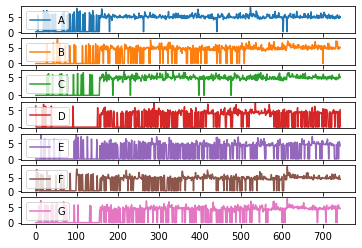

In [4]:
data_int.plot(subplots=True)

## Preparing Training Data

This time, we will use a sliding window of $\tau = 10 \text{ years} = 120 \text{ months}$ to predict the next 1 years. 

In [45]:
data_int.index = pd.to_datetime(data_int.time)
data_int.drop(["time"], axis=1, inplace=True)

In [46]:
from sklearn.preprocessing import StandardScaler

def create_sliding_window(data, sequence_length, stride=1, multi_steps=1):  # same goal as the previous split_data function
    """multi_steps: predicts multi_steps steps"""
    X, y = [], []
    for i in range(len(data)):
        if i + sequence_length + multi_steps - 1 < len(data):
            X.append(data.iloc[i : i + sequence_length : stride, :].values)
            y.append(data.iloc[i + sequence_length : i + sequence_length + multi_steps, :].values)
    return np.array(X), np.array(y)
        
n_train = 40 * 12  # December 2000
multi_steps = 12   # 1 years

features = ["C"]
feature_array = data_int[features].values

# Fit Scaler only on Training features
feature_scaler = StandardScaler()
feature_scaler.fit(feature_array[:n_train])

# Fit Scaler only on training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train])

# Transform on both Training and Test set
scaled_array = pd.DataFrame(feature_scaler.transform(feature_array))


sequence_length = 120 # 10 years
X, y = create_sliding_window(scaled_array, sequence_length, multi_steps=multi_steps)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((480, 120, 1), (480, 12, 1), (133, 120, 1), (133, 12, 1))

In [48]:
X_train_tensor = Variable(torch.Tensor(X_train))
X_test_tensor = Variable(torch.Tensor(X_test))

y_train_tensor = Variable(torch.Tensor(y_train))
y_test_tensor = Variable(torch.Tensor(y_test))

### Begin Training

In [49]:
n_features = scaled_array.shape[-1]
sequence_length = 120  # 10 years
output_length = 12  # 1 years

batch_size = 100
n_epochs = 60
learning_rate = 0.01

bayesian_lstm = BayesianLSTM(n_features=n_features,
                             output_length=output_length,
                             batch_size = batch_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=learning_rate)

In [50]:
bayesian_lstm.train()

for e in range(1, n_epochs+1):
    for b in range(0, len(X_train), batch_size):
        features = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]    

        X_batch = torch.tensor(features,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        output = bayesian_lstm(X_batch)
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    if e % 10 == 0:
      print('epoch', e, 'loss: ', loss.item())

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:520: UserWarning:

Using a target size (torch.Size([100, 12, 1])) that is different to the input size (torch.Size([1200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\torch\nn\modules\loss.py:520: UserWarning:

Using a target size (torch.Size([80, 12, 1])) that is different to the input size (torch.Size([960])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



epoch 10 loss:  0.07240385562181473
epoch 20 loss:  0.06372052431106567
epoch 30 loss:  0.05896371603012085
epoch 40 loss:  0.06128877028822899
epoch 50 loss:  0.06125863268971443
epoch 60 loss:  0.06162188574671745


In [20]:
test = bayesian_lstm.predict(X_train).reshape((600, 12))

In [28]:
test[0]  # 12 month prediction from first training example

[0.43833002,
 0.44455,
 0.44834998,
 0.43693513,
 0.44006425,
 0.43327376,
 0.44884488,
 0.44004577,
 0.44177616,
 0.4467904,
 0.44699955,
 0.44062936]

In [23]:
bayesian_lstm.predict(X_test).shape

(156,)

In [51]:
offset = sequence_length

def inverse_transform(y):
  return target_scaler.inverse_transform(y.reshape(-1, 1))

training_df = pd.DataFrame()
training_df['date'] = data_int.index[offset:n_train + offset:1] 
training_predictions_12 = bayesian_lstm.predict(X_train).reshape((480, 12))
training_df_12 = target_scaler.inverse_transform(training_predictions_12)
#training_df['C'] = inverse_transform(training_predictions)
training_df['source'] = 'Training Prediction'
training_df['C'] = np.array([training_df_12[i] for i in range(0, 480, 12)]).flatten()  # 12 months predictions (one evry 12 months)

training_truth_df = pd.DataFrame()
training_truth_df['date'] = training_df.index
training_truth_df['C'] = data_int['C'].iloc[offset:n_train + offset:1] 
training_truth_df['source'] = 'True Values'

testing_df = pd.DataFrame()
testing_df['date'] = data_int.index[n_train + offset::1] 
testing_predictions_12 = bayesian_lstm.predict(X_test).reshape((133, 12))
testing_df_12 = target_scaler.inverse_transform(testing_predictions_12)
#testing_df['C'] = inverse_transform(testing_predictions)
testing_df['source'] = 'Test Prediction'
testing_df['C'] = np.array([testing_df_12[i] for i in range(0, 133, 12)]).flatten()

testing_truth_df = pd.DataFrame()
testing_truth_df['date'] = testing_df['date']
testing_truth_df['C'] = data_int['C'].iloc[n_train + offset::1] 
testing_truth_df['source'] = 'True Values'

truthC = pd.DataFrame({"date": data_int.index, "C": data_int["C"].values, "source": ["True Values"]*len(data_int)})

evaluation = pd.concat([training_df, 
                        testing_df,
                        truthC
                        ], axis=0)

In [55]:
fig = px.line(evaluation.loc[evaluation['date'].between('2000', '2021')],
                 x="date",
                 y="C",
                 color="source",
                 title="EQ Intensity in zone C by month on a 12 month prediction basis")
fig.show()

In [56]:
fig = px.line(evaluation.loc[evaluation['date'].between('1960', '2021')],
                 x="date",
                 y="C",
                 color="source",
                 title="EQ Intensity in zone C by month on a 12 month prediction basis")
fig.show()

In [88]:
n_experiments = 20

test_uncertainty_df = pd.DataFrame()
test_uncertainty_df['date'] = data_int.index[n_train + offset:-11] 
full_experiment = []

for i in range(n_experiments):
  experiment_predictions_mat = bayesian_lstm.predict(X_test).reshape((133, 12))
  full_experiment.append(torch.from_numpy(target_scaler.inverse_transform(experiment_predictions_mat)))

full_experiment_t = torch.stack(full_experiment, 0)
std_mat = torch.std(full_experiment_t, dim=0, keepdim=True)
mean_mat = torch.mean(full_experiment_t, dim=0, keepdim=True)
test_uncertainty_df['mag_mean'] = mean_mat[0, :, 0]
test_uncertainty_df['mag_std'] = std_mat[0, :, 0]

test_uncertainty_df = test_uncertainty_df[['date', 'mag_mean', 'mag_std']]

In [89]:
test_uncertainty_df['lower_bound'] = test_uncertainty_df['mag_mean'] - 3*test_uncertainty_df['mag_std']
test_uncertainty_df['upper_bound'] = test_uncertainty_df['mag_mean'] + 3*test_uncertainty_df['mag_std']

In [93]:
import plotly.graph_objects as go

test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['date'].between('2000', '2021')]
truth_uncertainty_plot_df = truthC.copy(deep=True)
truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[truthC['date'].between('2000', '2021')]

upper_trace = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['upper_bound'],
    mode='lines',
    fill=None,
    name='99% Upper Confidence Bound'
    )
lower_trace = go.Scatter(
    x=test_uncertainty_plot_df['date'],
    y=test_uncertainty_plot_df['lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='99% Lower Confidence Bound'
    )
real_trace = go.Scatter(
    x=truth_uncertainty_plot_df['date'],
    y=truth_uncertainty_plot_df['C'],
    mode='lines',
    fill=None,
    name='Real Values'
    )

data = [upper_trace, lower_trace, real_trace]

fig = go.Figure(data=data)
fig.update_layout(title='Uncertainty Quantification of maximum EQ magnitude in zone C - 120 month lookback window',
                   xaxis_title='Time',
                   yaxis_title='Maximum magnitude')

fig.show()

In [97]:
bounds_df = pd.DataFrame()

# Using 99% confidence bounds
bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
bounds_df['prediction'] = test_uncertainty_plot_df['mag_mean']
bounds_df['real_value'] = truthC.loc[truthC['date'].between('2010', '2021')].C.values
bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                          (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points contained within 99% confidence interval:", 
      bounds_df['contained'].mean())

Proportion of points contained within 99% confidence interval: 0.5639097744360902
